In [2]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import os
from sklearn.impute import SimpleImputer
from sklearn import preprocessing
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns, matplotlib.pyplot as plt, operator as op
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, roc_curve, auc
import weka.core.converters as converters
import weka.core.jvm as jvm

In [4]:

jvm.start(packages=True)
import weka.core.packages as packages
packages.install_package("SMOTE")

DEBUG:weka.core.jvm:Adding bundled jars
DEBUG:weka.core.jvm:Classpath=['/usr/local/lib/python3.7/dist-packages/javabridge/jars/rhino-1.7R4.jar', '/usr/local/lib/python3.7/dist-packages/javabridge/jars/runnablequeue.jar', '/usr/local/lib/python3.7/dist-packages/javabridge/jars/cpython.jar', '/usr/local/lib/python3.7/dist-packages/weka/lib/weka.jar', '/usr/local/lib/python3.7/dist-packages/weka/lib/python-weka-wrapper.jar']
DEBUG:weka.core.jvm:MaxHeapSize=default
DEBUG:weka.core.jvm:Package support enabled


True

## 2. Tree-Based Methods

### a. Dowload APS data

In [5]:
APS_train = pd.read_csv('../data/aps_failure_training_set.csv')
APS_test = pd.read_csv('../data/aps_failure_test_set.csv')

### b. Data prep

#### i.  Missing values

In [9]:
APS_train = APS_train.replace('na',np.nan)
train_class = APS_train['class']
df_mean = SimpleImputer(missing_values = np.nan,strategy = 'median')
APS_train_x = df_mean.fit_transform(APS_train.drop('class',axis=1))
APS_train_x = pd.DataFrame(df_mean.fit_transform(APS_train_x),columns = APS_train.columns[1:])
APS_train_y_df = APS_train['class']
APS_train_y_df = APS_train_y_df.replace('neg',-1)
APS_train_y_df = APS_train_y_df.replace('pos',1)
APS_train_imp = pd.concat([APS_train_x,APS_train_y_df],axis=1)
APS_train_y = APS_train_y_df.tolist()

APS_test = APS_test.replace('na',np.nan)
test_class = APS_test['class']
df_mean = SimpleImputer(missing_values = np.nan,strategy = 'median')
APS_test_x = df_mean.fit_transform(APS_test.drop('class',axis=1))
APS_test_x = pd.DataFrame(APS_test_x,columns = APS_test.columns[1:])
APS_test_y_df = APS_test['class']
APS_test_y_df = APS_test_y_df.replace('neg',-1)
APS_test_y_df = APS_test_y_df.replace('pos',1)
APS_test_imp = pd.concat([APS_test_x,APS_test_y_df],axis=1)
APS_test_y = APS_test_y_df.tolist()
test_class_df = pd.DataFrame(test_class)
train_class_df=pd.DataFrame(train_class)
APS_train = pd.concat([APS_train_x,train_class_df],axis=1)
APS_test = pd.concat([APS_test_x,test_class_df],axis=1)

### e. Model Trees

In [10]:
APS_train.to_csv('weka_train.csv', index = False)
APS_test.to_csv('weka_test.csv', index = False)

In [11]:
from weka.core.converters import Loader
loader = Loader(classname = 'weka.core.converters.CSVLoader')
train = loader.load_file('weka_train.csv')
train.class_is_last()
test = loader.load_file('weka_test.csv')
test.class_is_last()

#### LMT on Train Data

97.40259740259741

Correctly Classified Instances         525               97.4026 %
Incorrectly Classified Instances        14                2.5974 %
Kappa statistic                          0.4038
Mean absolute error                      0.0367
Root mean squared error                  0.1534
Relative absolute error                 69.731  %
Root relative squared error             96.4143 %
Total Number of Instances              539     

=== Detailed Accuracy By Class ===

                 TP Rate  FP Rate  Precision  Recall   F-Measure  MCC      ROC Area  PRC Area  Class
                 0.990    0.643    0.983      0.990    0.987      0.410    0.852     0.987     neg
                 0.357    0.010    0.500      0.357    0.417      0.410    0.852     0.329     pos
Weighted Avg.    0.974    0.626    0.970      0.974    0.972      0.410    0.852     0.970     



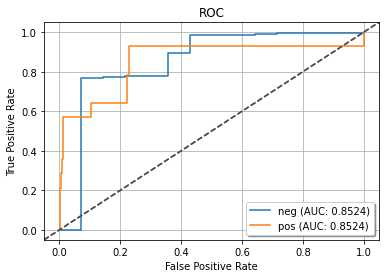

In [12]:
from weka.classifiers import Evaluation, Classifier
from weka.core.classes import Random
import weka.plot.classifiers as plcls  # NB: matplotlib is required



cls = Classifier(classname="weka.classifiers.trees.LMT")
evl = Evaluation(train)
evl.crossvalidate_model(cls, train, 5, Random(42))

print(evl.percent_correct)
print(evl.summary())
print(evl.class_details())


plcls.plot_roc(evl, class_index=[0, 1], wait=True)


In [13]:
evl.confusion_matrix

array([[520.,   5.],
       [  9.,   5.]])

#### LMT on Test Data

99.04761904761905

Correctly Classified Instances         208               99.0476 %
Incorrectly Classified Instances         2                0.9524 %
Kappa statistic                          0     
Mean absolute error                      0.4003
Root mean squared error                  0.4472
Relative absolute error               1627.621  %
Root relative squared error            457.8426 %
Total Number of Instances              210     

=== Detailed Accuracy By Class ===

                 TP Rate  FP Rate  Precision  Recall   F-Measure  MCC      ROC Area  PRC Area  Class
                 1.000    1.000    0.990      1.000    0.995      ?        0.601     0.992     neg
                 0.000    0.000    ?          0.000    ?          ?        0.601     0.012     pos
Weighted Avg.    0.990    0.990    ?          0.990    ?          ?        0.601     0.983     



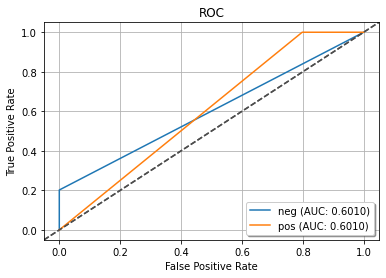

In [22]:
cls_ = Classifier(classname="weka.classifiers.trees.LMT")
evl_ = Evaluation(test)
evl_.crossvalidate_model(cls_, test, 5, Random(42))

print(evl_.percent_correct)
print(evl_.summary())
print(evl_.class_details())


plcls.plot_roc(evl_, class_index=[0, 1], wait=True)

In [23]:
evl_.confusion_matrix

array([[208.,   0.],
       [  2.,   0.]])

### f. SMOTE

97.40259740259741

Correctly Classified Instances         525               97.4026 %
Incorrectly Classified Instances        14                2.5974 %
Kappa statistic                          0.4038
Mean absolute error                      0.0367
Root mean squared error                  0.1534
Relative absolute error                 69.731  %
Root relative squared error             96.4143 %
Total Number of Instances              539     

=== Detailed Accuracy By Class ===

                 TP Rate  FP Rate  Precision  Recall   F-Measure  MCC      ROC Area  PRC Area  Class
                 0.990    0.643    0.983      0.990    0.987      0.410    0.852     0.987     neg
                 0.357    0.010    0.500      0.357    0.417      0.410    0.852     0.329     pos
Weighted Avg.    0.974    0.626    0.970      0.974    0.972      0.410    0.852     0.970     



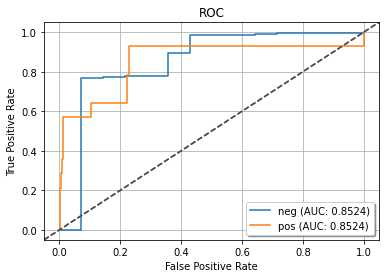

In [24]:
from weka.filters import Filter
from weka.classifiers import FilteredClassifier
from weka.classifiers import Evaluation, Classifier
from weka.core.classes import Random
import weka.plot.classifiers as plcls 

smote = Filter(classname='weka.filters.supervised.instance.SMOTE',options=['-P','1'])

cls_s = Classifier(classname="weka.classifiers.trees.LMT")
fc = FilteredClassifier()
fc.filter = smote
fc.classifier = cls_s
evl_s = Evaluation(train)
evl_s.crossvalidate_model(cls_s, train, 5, Random(42))

print(evl_s.percent_correct)
print(evl_s.summary())
print(evl_s.class_details())


plcls.plot_roc(evl_s, class_index=[0, 1], wait=True)



In [19]:
evl_s.confusion_matrix

array([[520.,   5.],
       [  9.,   5.]])

99.04761904761905

Correctly Classified Instances         525               97.4026 %
Incorrectly Classified Instances        14                2.5974 %
Kappa statistic                          0.4038
Mean absolute error                      0.0367
Root mean squared error                  0.1534
Relative absolute error                 69.731  %
Root relative squared error             96.4143 %
Total Number of Instances              539     

=== Detailed Accuracy By Class ===

                 TP Rate  FP Rate  Precision  Recall   F-Measure  MCC      ROC Area  PRC Area  Class
                 0.990    0.643    0.983      0.990    0.987      0.410    0.852     0.987     neg
                 0.357    0.010    0.500      0.357    0.417      0.410    0.852     0.329     pos
Weighted Avg.    0.974    0.626    0.970      0.974    0.972      0.410    0.852     0.970     



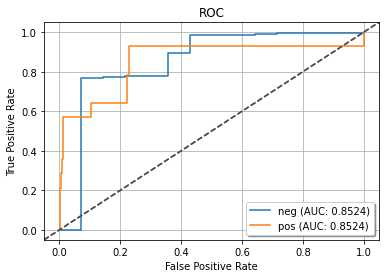

In [25]:
smote_ = Filter(classname='weka.filters.supervised.instance.SMOTE',options=['-P','1'])

cls_s_ = Classifier(classname="weka.classifiers.trees.LMT")
fc_ = FilteredClassifier()
fc_.filter = smote
fc_.classifier = cls_s_
evl_s_ = Evaluation(test)
evl_s_.crossvalidate_model(cls_s_, test, 5, Random(42))

print(evl_s_.percent_correct)
print(evl.summary())
print(evl.class_details())


plcls.plot_roc(evl, class_index=[0, 1], wait=True)

In [26]:
evl_s_.confusion_matrix

array([[208.,   0.],
       [  2.,   0.]])

Comparison: Raw data perform better than SMOTE data